In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

## Parameters

In [201]:
T = 60 # length of simulation 20=1 month, 60 = three months
S0 = 100 # starting price
K = 100 # strike price
sigma = 0.2 # volatility
r = 0 # risk-free rate
q = 0 # dividend yield
mu = 0.05 # expected return on stock
kappa = 0.01 # trading cost per unit traded
dt = 1 # hedging time step
notional = 1 # how many stocks the option is on
rho = -0.4 # correlation of stochastic volatility process
v = 0.6
sigma0 = 0.2 # starting volatility
c = 1.5 #standard deviation coefficient
ds = 0.01

n = 10000 # number of simulatied paths
days = 250 # number of days in a year
freq = 1 # trading frequency
np.random.seed(100)

## Simulation

### GBM

In [113]:
def CallBS(t, T, K, S, r, q, sigma): #[DONE]
    '''
    Calculates the price and the delta of a call option using the Black-Scholes formula.
    Inputs:
        t = current time
        T = expiry time
        K = strike price
        S = current stock price
        r = risk-free rate
        q = dividend yield
        sigma = volatility
    Outputs:
        P = option price
        delta = option delta
    '''
    d1 = (np.log(S/K) + (r -q + 0.5*sigma**2)*(T-t)) / (sigma* np.sqrt(T-t))
    d2 = d1 - (sigma* np.sqrt(T-t))
    
    # price
    P = S * np.exp(-q*(T-t))* norm.cdf(d1) - np.exp(-r*(T-t)) * K * norm.cdf(d2) 
    
    # delta
    delta = np.exp(-q*(T-t))*norm.cdf(d1)

    return P, delta

In [114]:
def GBM_sim(n, T, dt, S0, mu, r, q, sigma, days, freq): #[DONE]
    '''
    Simulates the price of the underlying with a geometric brownian motion model (Black-Scholes model), from time 0 to final time T.
    Inputs:
        n =     [float] number of paths
        T =     [float] time to expiry
        dt =    [float] time step, function of frequency (e.g. freq*0.01)
        S0 =    [float] current (starting) price
        mu =    [float] return on asset
        r =     [float] risk-free rate
        q =     [float] dividend yield
        sigma = [float] volatility
        days =  [int] number of days in year
        freq =  [float] trading frequency (e.g. 2 = every two days, 0.5 = every day twice)
    Output:
        S =     [array] simulated underlying price process
    '''
    T = int(T/freq) # adjust T to frequency
    
    # initialise variables
    S = np.zeros((n, T))  # Underlying price path

    S[:, 0] = S0
    # generate price path based on random component and derive option price and delta   
    for t in tqdm(range(1, T)):  # generate paths
        dW = np.random.normal(0, 1, size=(n)) # standard normal random variable
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5*sigma**2)*dt/days + sigma*np.sqrt(dt/days)*dW) # BS Model of Stock Price 

    
    return S

### SABR

In [217]:
def SABR_sim(n, days, freq, T, dt, S0, sigma0, v, rho, mu): #[DONE]
    '''
    Simulates the price of the underlying with a special case of the SABR model (beta = 1), from time 0 to final time T.
    Calculates the option price and delta at all time steps using the Black-Scholes option pricing formula.
    Inputs:
        n =           [float] number of simulations
        days =        [int] number of days in a year
        freq =        [float] trading frequency
        T =           [float] end time (expiry)
        dt =          [float] time step
        S0 =          [float] current (starting) price
        sigma0 =     [float] initial volatility
        v =           [float] volatility of underlying volatility
        rho =         [float] correlation of the two Brownian Motions
    Output:
        S =           [array] simulated price process
        sigma_stoch = [array] simulated stochastic volatility process
    '''

    T = int(T/freq) # adjust T to frequency

    # initialise variables
    sigma_stoch = np.zeros((n, T)) # Underlying stochastic volatility path
    S = np.zeros((n, T))  # Underlying price path

    sigma_stoch[:, 0] = sigma0
    S[:, 0] = S0
 
    # generate parameters for creating correlated random numbers
    mean = np.array([0,0])
    Corr = np.array([[1, rho], [rho, 1]]) # Correlation matrix
    STD = np.diag([1,1]) # standard deviation vector
    Cov = STD@Corr@STD # covariance matrix, input of multivariate_normal function


    # generate price path based on random component and derive option price and delta
    for t in tqdm(range(1,T)):  
        dW = np.random.multivariate_normal(mean, Cov, size = n)  # correlated random BM increments
        sigma_stoch[:, t] = sigma_stoch[:, t-1]*np.exp((-0.5*v**2)*dt/days + v*np.sqrt(dt/days)*dW[:, 0]) # GBM model of volatility
        S[:, t] = S[:, t-1]*np.exp((mu - 0.5*sigma_stoch[:, t]**2)*dt/days + sigma_stoch[:, t]*np.sqrt(dt/days)*dW[:, 1]) # Black-Scholdes GBM model of underlying price


    return S, sigma_stoch

In [218]:
def SABR_IV(sigma_stoch, t, T, S, K, r, q, v, rho):
    # future price
    f = S * np.exp((r - q) * (T-t))
    # at the money case
    atm = sigma_stoch * (1+(T-t)*(rho * v * sigma_stoch/4  + v**2 * (2-3 * rho**2)/24))
    xi = (v/ sigma_stoch) * np.log(f / K)
    xi_func = np.log((np.sqrt(1 - 2 * rho * xi + xi**2) + xi - rho) / (1 - rho))

    imp_vol = np.where(f == K, atm, atm * xi / xi_func)

    return imp_vol

In [219]:
def bartlett_delta(T, t, S, K, ivol, ds, rho, v):
    # Find Bartlett's delta using numerical differentiation
    d_volatility = ds * v * rho/S # following Bartlett (2006) Eq. 12 and using 

    i_sigma = SABR_IV(ivol, t, T, S, K, r, q, v, rho)
    i_sigma_plus = SABR_IV(ivol + d_volatility, t, T, S + ds, K, r, q, v, rho)

    p_base, _ = CallBS(t, T, K, S, r, q, i_sigma)
    p_plus, _ = CallBS(t, T, K, S + ds, r, q, i_sigma_plus)

    # finite differences
    bartlett_delta = (p_plus-p_base) / ds

    return bartlett_delta

### Implementation

In [220]:
def simulateGBM(n, T, dt, S0, mu, r, q, sigma, days, freq):
    S_gbm = GBM_sim(n, T, dt, S0, mu, r, q, sigma, days, freq)
    times = np.arange(0,T,freq)
    p_gbm, d_gbm = CallBS(times/days, T/days, K, S_gbm, r, q, sigma)

    return S_gbm, p_gbm, d_gbm

In [221]:
def simulateSABR (n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v):
    S_sabr, s_sabr = SABR_sim(n, days, freq, T, dt, S0, sigma, v, rho, mu)
    times = np.arange(0,T,freq)
    iv_SABR = SABR_IV(s_sabr, times/days, T/days, S_sabr, K, r, q, v, rho)
    p_sabr, delta_sabr= CallBS(times/days, T/days, K, S_sabr, r, q, s_sabr)
    bl_delta_sabr = bartlett_delta(T/days, times/days, S_sabr, K, iv_SABR, ds, rho, v)

    return S_sabr, s_sabr, iv_SABR, p_sabr, delta_sabr, bl_delta_sabr

    SABR_sim(n, days, freq, T, dt, S0, sigma0, v, rho, mu)

In [222]:
S_sabr_test, s_sabr_test, iv_sabr_test, p_sabr_test, delta_sabr_test, bl_delta_sabr_test = simulateSABR (
    n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v)

100%|██████████| 59/59 [00:00<00:00, 325.97it/s]
/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_5934/2359620205.py:9: RuntimeWarning: invalid value encountered in true_divide
  imp_vol = np.where(f == K, atm, atm * xi / xi_func)


## OU Process

In [60]:
def OU(X0, beta, alpha, sigmaOU, n, T, freq, days, dt):
    '''Generates an Ornstein-Uhlenbeck simulation
    Inputs:
        dt = freq*0.01 for example or just freq*1
    '''

    T = int(T/freq)
    X = np.zeros((n,T))
    X[:,0] = X0
    
    for t in range(1,T):
        dW = np.random.normal(0, 1, size=(n))
        X[:,t] = (1-beta)*X[:,t-1] + alpha*beta + sigmaOU*np.sqrt(dt/days)*dW
    
    return X

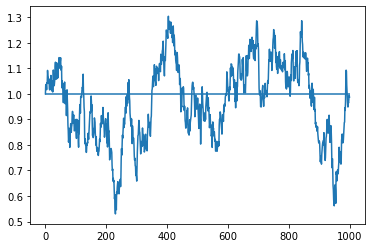

In [74]:
X0 = 1
beta = 0.01
alpha = 1
sigmaOU = 0.5

X = OU(X0, beta, alpha, sigmaOU, n, 1000, freq, days, dt)

plt.plot(X[0,:].T)
plt.hlines(alpha, 0, 1000)
plt.show()

## Classical Delta Hedging (Benchmark)

In [258]:
def hedgingStrategy(method,notional, n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v):
    '''
    Implements delta hedging for GBM model and delta hedging and bartlett hedging for SABR model.
    '''
    if method == "GBM":
        S_gbm, p_gbm, d_gbm = simulateGBM(n, T, dt, S0, mu, r, q, sigma, days, freq)
        trading_gbm = np.diff(d_gbm, axis = 1)
        trading_gbm = np.concatenate((d_gbm[:,0].reshape(-1,1), trading_gbm), axis=1)
        trading_gbm *= notional
        holding_gbm = d_gbm*notional

        return S_gbm, p_gbm, d_gbm, trading_gbm, holding_gbm

    if method == "SABR":
        # sabr delta hedging
        S_sabr, s_sabr, iv_SABR, p_sabr, delta_sabr, bl_delta_sabr = simulateSABR(n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v)
        trading_sabr = np.diff(delta_sabr, axis = 1)
        trading_sabr = np.concatenate((delta_sabr[:,0].reshape(-1,1), trading_sabr), axis=1)*notional
        trading_sabr *= notional
        holding_sabr = delta_sabr*notional

        # sabr bartlett delta hedging
        trading_sabr_bartlett = np.diff(bl_delta_sabr, axis = 1)
        trading_sabr_bartlett = np.concatenate((bl_delta_sabr[:,0].reshape(-1,1), trading_sabr_bartlett), axis=1)
        trading_sabr_bartlett *= notional
        holding_sabr_bartlett = bl_delta_sabr*notional

        return S_sabr, p_sabr, delta_sabr, bl_delta_sabr, trading_sabr, holding_sabr, trading_sabr_bartlett, holding_sabr_bartlett

In [351]:
S_gbm, p_gbm, d_gbm, trading_gbm, holding_gbm = hedgingStrategy("GBM",notional, n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v)
S_sabr, p_sabr, delta_sabr, bl_delta_sabr, trading_sabr, holding_sabr, trading_sabr_bartlett, holding_sabr_bartlett = hedgingStrategy(
    "SABR",notional, n, T, dt, S0, mu, r, q, sigma, days, freq, rho, ds, v)

100%|██████████| 59/59 [00:00<00:00, 290.44it/s]
/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_5934/2359620205.py:9: RuntimeWarning: invalid value encountered in true_divide
  imp_vol = np.where(f == K, atm, atm * xi / xi_func)


## Evaluation

In [329]:
def APL_process(S, p, holding):
    '''
    Calculates the Accounting PnL process for a portfolio of an option, the underlying, with proportional trading costs
    Inputs:
        S =              [array] underlying price process
        p =              [array] option price process (adjusted for number of underlying)
        holding =        [array] process of number of the underlying held at each period
    Output:
        APL =            [array] process of Accounting PnL
        holding_lagged = [array] lagged process of number of underlying held at each period
    '''
    # create lagged variables for APL
    p_lagged = np.roll(p, 1)
    p_lagged[:, 0] = np.nan # the first element was p[-1], this has to be changed to NaN
    S_lagged = np.roll(S, 1)
    S_lagged[:, 0] = np.nan # the first element was S[-1], this has to be changed to NaN
    holding_lagged = np.roll(holding, 1)
    holding_lagged[:, 0] = np.nan # the first element was holding[-1], this has to be changed to NaN
    


    # accounting PnL
    APL = p - p_lagged + holding_lagged*(S-S_lagged) - kappa* np.abs(S*(holding - holding_lagged)) 

    return APL, holding_lagged

In [331]:
def hedgingCost(kappa, S, holding, holding_lagged):
    '''
    Calculates the total hedging cost from time t onward for all t
    Inputs:
        kappa =           [float] proportional hedging cost parameter
        S =               [array] underlying price process
        holding =         [array] process of amount of the underlying asset held at any given time t
        holding_lagged =  [array] process of amount of the underlying asset held at any given time t-1
    Output:
        C =               [array] total hedging cost from time t onward
    '''
    # Hedging cost at each period
    hedging_cost = kappa* np.abs(S*(holding - holding_lagged))

    # The reverse cumulative sum represents the remaining total hedging cost from time t onwards
    # The remaining total hedging cost C_t, is calculated at the beginning of each period t (before hedging transaction at time t is made)
    #C = np.nancumsum(hedging_cost[::-1])[::-1] 

    return hedging_cost

In [344]:
def objective(C, c):
    '''
    Calculates the loss from time t (present) to time T (expiry).
    Input:
        C = [array] total hedging cost
        c = [float] weight of standard deviation
    Output:
        Y = [array] loss function over time
    '''
    Y = np.zeros(C.shape)

    for t in range(C.shape[1]):
        Y[:,t] = \
            np.nanmean(C[:, :(t+1)], axis = 1) + \
            c*np.nanstd(C[:, :(t+1)], axis = 1)

    return Y

### Implementation

In [352]:
# GBM delta
APL_gbm, holding_lagged_gbm = APL_process(S_gbm, p_gbm, holding_gbm)
hedging_cost_gbm = hedgingCost(kappa, S_gbm, holding_gbm, holding_lagged_gbm)
Y_gbm = objective(hedging_cost_gbm, c)
print(np.mean(Y_gbm[:,-1]))
print(np.std(Y_gbm[:,-1]))

/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_5934/1228649935.py:14: RuntimeWarning: Mean of empty slice
  np.nanmean(C[:, :(t+1)], axis = 1) + \


0.10155949128222713
0.0348503802683715


In [355]:
# SABR delta
APL_sabr, holding_lagged_sabr = APL_process(S_sabr, p_sabr, holding_sabr)
hedging_cost_sabr = hedgingCost(kappa, S_sabr, holding_sabr, holding_lagged_sabr)
Y_sabr = objective(hedging_cost_sabr, c)
print(np.mean(Y_sabr[:,-1]))
print(np.std(Y_sabr[:,-1]))

/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_5934/1228649935.py:14: RuntimeWarning: Mean of empty slice
  np.nanmean(C[:, :(t+1)], axis = 1) + \
/Users/Marcell/Applications/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.10049817975104944
0.03470000411911707


In [356]:
# SABR Bartlett
APL_sabr_bl, holding_lagged_sabr_bl = APL_process(S_sabr, p_sabr, holding_sabr_bartlett)
hedging_cost_sabr_bl = hedgingCost(kappa, S_sabr, holding_sabr_bartlett, holding_lagged_sabr_bl)
Y_sabr_bl = objective(hedging_cost_sabr_bl, c)
print(np.mean(Y_sabr_bl[:,-1]))
print(np.std(Y_sabr_bl[:,-1]))

/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_5934/1228649935.py:14: RuntimeWarning: Mean of empty slice
  np.nanmean(C[:, :(t+1)], axis = 1) + \
/Users/Marcell/Applications/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.10072801502250124
0.034754623093770545


## Save data

In [ ]:
'''
# define data
# save to csv file
np.savetxt('asset_price_GBM_5_sim.csv', S_gbm, delimiter=',')
np.savetxt('option_price_GBM_5_sim.csv', p_gbm, delimiter=',')
np.savetxt('asset_price_SABR_5_sim.csv', S_sabr, delimiter=',')
np.savetxt('option_price_SABR_5_sim.csv', p_sabr, delimiter=',')
'''

"\n# define data\n# save to csv file\nnp.savetxt('asset_price_GBM_5_sim.csv', S_gbm, delimiter=',')\nnp.savetxt('option_price_GBM_5_sim.csv', p_gbm, delimiter=',')\nnp.savetxt('asset_price_SABR_5_sim.csv', S_sabr, delimiter=',')\nnp.savetxt('option_price_SABR_5_sim.csv', p_sabr, delimiter=',')\n"

In [ ]:
'''
S_mixed = np.vstack((S_gbm, S_sabr))
p_mixed = np.vstack((p_gbm, p_sabr))
print(S_mixed.shape)
print(p_mixed.shape)
np.savetxt("asset_price_mixed_5_sim.csv", S_mixed, delimiter=",")
np.savetxt("option_price_mixed_5_sim.csv", p_mixed, delimiter=",")
'''

'\nS_mixed = np.vstack((S_gbm, S_sabr))\np_mixed = np.vstack((p_gbm, p_sabr))\nprint(S_mixed.shape)\nprint(p_mixed.shape)\nnp.savetxt("asset_price_mixed_5_sim.csv", S_mixed, delimiter=",")\nnp.savetxt("option_price_mixed_5_sim.csv", p_mixed, delimiter=",")\n'

In [197]:
def APL_process(p, S, holding):
    '''
    Calculates the Accounting PnL process for a portfolio of an option, the underlying, with proportional trading costs
    Inputs:
        S =              [array] underlying price process
        p =              [array] option price process (adjusted for number of underlying)
        holding =        [array] process of number of the underlying held at each period
    Output:
        APL =            [array] process of Accounting PnL
        holding_lagged = [array] lagged process of number of underlying held at each period
    '''
    # create lagged variables for APL
    p_lagged = np.roll(p, 1)
    p_lagged[0] = np.nan # the first element was p[-1], this has to be changed to NaN
    S_lagged = np.roll(S, 1)
    S_lagged[0] = np.nan # the first element was S[-1], this has to be changed to NaN
    holding_lagged = np.roll(holding, 1)
    holding_lagged[0] = np.nan # the first element was holding[-1], this has to be changed to NaN
    


    # accounting PnL
    APL = p - p_lagged + holding_lagged*(S-S_lagged) - kappa* np.abs(S*(holding - holding_lagged)) 
    APL_unhedged = p-p_lagged

    return APL, holding_lagged, APL_unhedged

In [198]:
def hedgingCost(kappa, S, holding, holding_lagged):
    '''
    Calculates the total hedging cost from time t onward for all t
    Inputs:
        kappa =           [float] proportional hedging cost parameter
        S =               [array] underlying price process
        holding =         [array] process of amount of the underlying asset held at any given time t
        holding_lagged =  [array] process of amount of the underlying asset held at any given time t-1
    Output:
        C =               [array] total hedging cost from time t onward
    '''
    # Hedging cost at each period
    hedging_cost = kappa* np.abs(S*(holding - holding_lagged))

    # The reverse cumulative sum represents the remaining total hedging cost from time t onwards
    # The remaining total hedging cost C_t, is calculated at the beginning of each period t (before hedging transaction at time t is made)
    C = np.nancumsum(hedging_cost[::-1])[::-1] 

    return C

In [199]:
def objective(C, c):
    '''
    Calculates the loss from time t (present) to time T (expiry).
    Input:
        C = [array] total hedging cost, C[t] = total hedging cost from time t until T
        c = [float] weight of standard deviation
    Output:
        Y = [array] loss function over time, Y[t] = loss at time t
    '''
    Y = np.zeros(len(C))

    for t in range(len(C)):
        Y[t] = np.mean(C[t:]) + c*np.std(C[t:])

    return Y

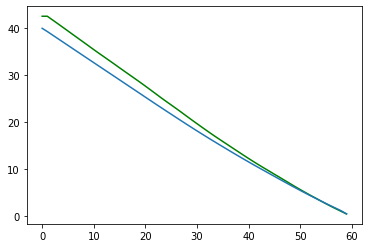

In [ ]:
C = hedgingCost(kappa, S, holding, holding_lag)
Y = objective(C, c)
plt.plot(C, c = 'g')
plt.plot(Y)
plt.show()
